In [1]:
!pip install gradio
!pip install keybert

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [1]:
# Imports
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import numpy as np
from PIL import Image
import gradio as gr
import sys
import openai
sys.path.append("../")
import speech_recognition as sr
import pygame
from pygame import mixer
import cv2
from vosk import Model, KaldiRecognizer, SetLogLevel
from pydub import AudioSegment
import wave
import json
from Talking_Head.Talking_Head import Talking_Head
from putting_it_together import blink_loop
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import multiprocess
import gradio as gr
import time
import numpy as np
from copy import deepcopy
import asyncio
import threading
import pygame
from pygame import mixer

pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from putting_it_together import WaifuObj

In [3]:
# Audio recognizer
r = sr.Recognizer()

In [4]:
# Path to the custom audio model
audio_model_path = "../Audio_Generation/Generation_Scripts/saved_models/default"

# Path to the custom audio data
audio_data_path = "../Audio_Generation/Generation_Scripts/data/albedo"

# Path to the custom model to load in
custom_model_path = "../Finetuning/outputs/r/"

In [5]:
# The initial summary is initially a basic prompt telling GPT-3 who it is
initial_summ = "You are my female waifu girlfriend who loves me."\
# The initial prompt tells GPT-3 how to respond
initial_prompt = "Me: Hi\nYou: Hello\n\n"\
    "Me: How are you?\nYou: Good. How are you?\n\n"\
    "Me: I'm good.\nYou: Nice to meet you.\n\n"

In [6]:
# Setup function to setup the environment
memory_file = "config_file.json"
# memory_file = None
Module = WaifuObj(initial_summ, initial_prompt, False, audio_model_path, audio_data_path, custom_model_path, memory_file)

Initializing image model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Image model initialized!
Initializing custom text model
Custom text model initialized!
Not loading custom audio model


In [7]:
device = torch.device("cuda:0")

In [8]:
# Load in the image
# img = Image.open("test.png")
img = Image.open("../Talking_Head/data/illust/../../../test5.png")

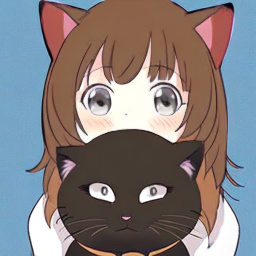

In [9]:
# Let's make a global Talking Head class to store the global vector
global img_anim
img_anim = Talking_Head(torch.device("cuda:0"), 0.5, automatic_EMA=True)

# Load in the new image
img_anim.load_new_image(img=deepcopy(img))

# Default pose for the image
img_anim.change_pose()

In [10]:
# Function to extract the word data from a mp3 file
def extract_word_data(filename):
    # Load in the model
    model_path = "../vosk_models/vosk-model-small-en-us-0.15"
    model = Model(model_path)
    
    # Make the audio a wav file
    f = AudioSegment.from_mp3("tmp.mp3")
    f.export("tmp.wav", format="wav")
    
    # Read in the audio
    with wave.open("tmp.wav", "rb") as wf:
        # Prepare the model for rekognition
        rec = KaldiRecognizer(model, wf.getframerate())
        rec.SetWords(True)

        # get the list of JSON dictionaries
        results = []
        # recognize speech using vosk model
        data = wf.readframes(wf.getnframes())
        while len(data) > 0:
            if rec.AcceptWaveform(data):
                part_result = json.loads(rec.Result())
                results.append(part_result)
            data = wf.readframes(wf.getnframes())
        part_result = json.loads(rec.FinalResult())
        results.append(part_result)
    
    audio_trans = results[0]["result"]
    
    # Get the delay between each word
    for i in range(1, len(audio_trans)):
        audio_trans[i]["delay"] = audio_trans[i]["start"]-audio_trans[i-1]["end"]
    audio_trans[0]["delay"] = audio_trans[0]["start"]
    
    return audio_trans

In [11]:
# Literally all this function does is update the
# eye part of the vector every so often
global DONE
DONE = False
async def blink_loop():
    global img_anim
    
    # We want to iterate forever
    while not DONE:
        # Wait a little to blink again
        if img_anim.eye_cycle_end:
            # Blink anywhere between 2 and 7 secods with
            # a mean around 5 seconds (avg blink wait time)
            t = np.clip(np.random.normal(5, 1, size=1)[0], 2, 7)

            # Wait a little before blinking again
            time.sleep(t)
            img_anim.eye_cycle_end = False
        
        # Update the vector
        img_anim.Move_eyes()
        
        # Wait for a new frame to be generated
        while img_anim.eye_frame_disp == False:
            time.sleep(0.001)

# Used to make a thread running the blink loop
def run_blink_loop():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    loop.run_until_complete(blink_loop())
    loop.close()

In [12]:
async def talk_loop(filename):
    global img_anim
    global generating_mouth_movement
    
    # Get the audio transcript
    audio_trans = extract_word_data(filename)
    
    # Play the audio
    mixer.init()
    mixer.stop()
    mixer.music.unload()
    try:
        mixer.music.load('tmp.mp3')
        mixer.music.play()
    except pygame.error:
        s = mixer.Sound('tmp.mp3')
        s.play()
    
    # Iterate over all parts of the audio transcription
    generating_mouth_movement = True
    for part in audio_trans:
        # Get the beginning and end of the audio piece
        start = part["start"]
        end = part["end"]
        delay = part["delay"]
        
        # Wait for the next audio part according to the
        # delay in teh audio
        time.sleep(delay)
        
        # Get the entire audio clip length
        length = end-start
        
        # Setup the mouth movement cycle
        img_anim.setup_mouth_movement(length)
        
        # Iterate until the movement is done for this part
        while img_anim.mouth_cycle_end == False:
            # Update the vector
            img_anim.Move_mouth()
            
            # Wait for a new frame to be generated
            while img_anim.mouth_frame_disp == False:
                time.sleep(0.001)
                
    generating_mouth_movement = False
            
#             # Change the pose and show the image
#             img = img_anim.change_pose()
            
#             # End EMA timer and update EMA
#             if timer_s != -1:
#                 img_anim.update_EMA(time.time()-timer_s)
            
#             # Start timer for EMA
#             timer_s = time.time()
            
#             yield img
    
    
# Used to make a thread running the talk loop
def run_talk_loop(filename):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    loop.run_until_complete(talk_loop(filename))
    loop.close()

In [13]:
global generating_mouth_movement
generating_mouth_movement = False

def event_loop():
    global img_anim
    global generating_mouth_movement
    
    # Quick calibration. Blink 10 times
    # and calibrate the time it takes
    # to show the image for the EMA
    for i in range(0, 10):
        s = time.time()
        img_anim.eye_cycle_end = False
        while img_anim.eye_cycle_end == False:
            img_anim.Move_eyes()
            img = img_anim.change_pose()
            img_anim.update_EMA(time.time()-s)
            s = time.time()
            yield img
    img_anim.eye_cycle_end = False
    
    # Start the blink loop
    b_thread = threading.Thread(target=run_blink_loop, args=())
    b_thread.start()
    
    while True:
        # Wait until a new frame needs to be generated
        if generating_mouth_movement == True:
            if img_anim.mouth_frame_disp == False:
                # Change the pose and show the image
                img = img_anim.change_pose()

                yield img
        else:
            # Start the mouth movement loop
            # m_thread = threading.Thread(target=run_talk_loop, args=("tmp.mp3",))
            # m_thread.start()
            # generating_mouth_movement = True
            if img_anim.eye_frame_disp == False:
                # Change the pose and show the image
                img = img_anim.change_pose()

                yield img
        
        time.sleep(0.0001)
    
    global DONE
    DONE = True
    b_thread.join()
    m_thread.join()
    
#     m_thread = threading.Thread(target=run_mouth_loop, args=())
#     m_thread.start()
    
#     while True:
#         # If the mouth loop ended, reset it
#         if img_anim.mouth_cycle_end == True:
#             m_thread.join()
#             img_anim.setup_mouth_movement(1)
            
#             m_thread = threading.Thread(target=run_mouth_loop, args=())
#             m_thread.start()
        
#         # Change the pose and show the image
#         img = img_anim.change_pose()
#         yield img

In [14]:
# io = gr.Interface(event_loop, inputs=[], outputs=[gr.Image().style(height=330)])
# io.queue().launch()

In [ ]:
global m_thread
m_thread = None


def build_img_prompt(text, settings, characteristics):
    # Get the summary and sentiment
    sent = get_sent(text)
    summary = get_summ(text)
    
    # Create the image prompt
    # settings = "1girl, very wide shot, simple background, solo focus, female focus, looking at viewer, ratio:16:9, detailed"
    # characteristics = "waifu, female, brown hair, blue eyes, sidelocks, slight blush, fox ears"
    # sent = "furious"
    # summary = "'I hope get know better' to viewer"
    img_prompt = f"{settings} {characteristics} {','+sent if len(sent)!=0 else ''}, {summary}"
    return img_prompt


def text_to_image(settings, characteristics, guidance_scale, text):
    # Get the image prompt
    img_prompt = Module.build_img_prompt(text, settings, characteristics)
    
    # Get the image
    with Module.suppress_stdout():
        with autocast("cuda"):
            image = Module.imgGen(img_prompt, guidance_scale=guidance_scale)["images"]
            
    
    return image

# Overall function to generate audio,
# text, and images
def generate(custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio_pth, GPT_key):
    global prompt
    global last_image
    global last_text
    global generating_mouth_movement
    global m_thread
    if m_thread is not None:
        m_thread.join()
    
    # Get the audio if there is any
    if audio_pth:
        # Open the wav file and read in the data
        # Get the audio data
        audio = sr.AudioFile(audio_pth)
        with audio as source:
            audio = r.record(source)
        
        text = audio_to_text(audio)
    
    # Add the text to the current prompt
    Module.cur_prompt += f"Me: {text}\n"
    
    # Get the response
    if custom_model == True:
        ret_text = Module.get_response()
    else:
        try:
            ret_text = ret_text = Module.get_response(GPT_key)
        except:
            gr.Error("GPT key is either invalid or not given")
            return last_image, "Error: GPT key is either invalid or not given."
    
    # Create audio and image for the returned text
    if len(ret_text) > 3:
        
        # Create the audio clip
        mixer.stop()
        mixer.music.unload()
        Module.create_audio(ret_text, custom_audio)
        
        # Start the mouth movement loop
        generating_mouth_movement = True
        m_thread = threading.Thread(target=run_talk_loop, args=("tmp.mp3",))
        m_thread.start()
        
        return ret_text
#         # Create the audio clip
#         mixer.stop()
#         mixer.music.unload()
#         Module.create_audio(ret_text, custom_audio)

#         # Play the audio
#         try:
#             mixer.music.load('tmp.mp3')
#             mixer.music.play()
#         except Module.pygame.error:
#             s = mixer.Sound('tmp.mp3')
#             s.play()
            
#         # Generate an image from the text
#         image = text_to_image(settings, characteristics, guidance_scale, ret_text)[0]
        
#         # Save the image and text
#         last_image = image
#         last_text = ret_text
        
#         # Return the image
#         return image, ret_text
    
# Transcribes audio to text
def audio_to_text(audio):
    try:
        text = r.recognize_google(audio)
    except sr.UnknownValueError:
        text = "" # Default to nothing
            
    return text


def audio_auto_submit(custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio_pth, GPT_key):
    if audio_pth != None:
        return generate(custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio_pth, GPT_key)
    global last_image
    global last_text
    return last_image, last_text

# Incase of an error, these can be used
global last_image
global last_text
last_image = np.zeros((50, 50, 3))
last_text = "Error"

# Initialize the audio mixer
mixer.init()
mixer.music.unload()


def load_mem(filename):
    try:
        Module.load_memory(filename)
        return "Success!"
    except:
        return "Fail! File does not exist or is in incorrect format"


interface = gr.Blocks()
with interface:
    with gr.Tabs():
        with gr.TabItem("Generation"):
            # Talking to the AI
            with gr.Tabs():
                with gr.TabItem("Voice-based Chat"):
                    audio = gr.Audio(source="microphone", type="filepath", label="Response", live=True)
                with gr.TabItem("Text-based Chat"):
                    text = gr.Textbox(label="Text", value="I love you!", interactive=True)
            response = gr.Textbox(label="Response", value="", interactive=False)
                

            # Note gallery expects a 3-D array: (L, W, 3)
            gallery = gr.Image(label="Generated images", show_label=False)\
                .style(height=512)

            # Button to generate a new image
            btn = gr.Button("Generate")
            
            # Button for live image
            btn_live = gr.Button("Live")
            
            
        with gr.TabItem("Settings"):
            # Switched for which model to use
            custom_model = gr.Checkbox(value=True, label="Use custom chat model? (False to use GPT, True to use custom model)")
            GPT_key_ = gr.Textbox(label="Key to use GPT-3 (if using GPT-3)\nNote: If you don't have one go here: https://elephas.app/blog/how-to-create-openai-api-keys-cl5c4f21d281431po7k8fgyol0", value="", interactive=True)
            custom_audio = gr.Checkbox(value=False, label="Use custom audio model?")

            # Settings for the image
            settings = gr.Textbox(label="Settings", value= "1girl, very wide shot, simple background, solo focus, female focus, looking at viewer, ratio:16:9, detailed", interactive=True)
            characteristics = gr.Textbox(label="Characteristics", value="waifu, female, brown hair, blue eyes, sidelocks, slight blush", interactive=True)
            guidance_scale = gr.Number(label="Guidance value - Tradeoff between creativity and image fidelity (greater than 1.0)", value=10.0, interactive=True, precision=1)
            
            # Load in some memory
            with gr.Column():
                mem_file = gr.Textbox(label="Memory File", value= "", interactive=True)
                with gr.Row():
                    mem_load_btn = gr.Button("Load memory file")
                    mem_file_success = gr.Textbox(label="Was the load successful?", value= "", interactive=False)
                    mem_load_btn.click(fn=load_mem, inputs=[mem_file], outputs=[mem_file_success])
            
            
        audio.change(audio_auto_submit, inputs=[custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio, GPT_key_], outputs=[response])
        btn.click(fn=generate, inputs=[custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio, GPT_key_], outputs=[response])
        text.submit(fn=generate, inputs=[custom_audio, custom_model, settings, characteristics, guidance_scale, text, audio, GPT_key_], outputs=[response])
        
        # Live image button takes constant output. This button
        # starts a function that doesn't end until clicked again
        btn_live.click(fn=event_loop, inputs=[], outputs=[gallery], queue=True)

interface.queue(concurrency_count=2).launch(debug=True, share=False)

In [ ]:
Module.past_summ